In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)

In [6]:
df = pd.read_csv('/Users/saurav/Downloads/DS_test_analysis.tsv', sep='\t')

In [44]:
df.head()

,date,version,location,device,browser,visits,bounce_rate,time_on_page,conversions,interacted_visited,interacted_visits
0,2017-10-01,0,Australia,Desktop,Chrome,981,0.39,186,0,598.41,598.41
1,2017-10-01,0,Australia,Desktop,Safari,176,0.51,172,2,86.24,86.24
2,2017-10-01,0,Australia,Desktop,Other,241,0.43,127,1,137.37,137.37
3,2017-10-01,0,Australia,Tablet,Chrome,220,0.47,159,2,116.60,116.60
4,2017-10-01,0,Australia,Tablet,Safari,93,0.34,135,1,61.38,61.38


In [18]:
for column in df.columns:
    n_unique = len(np.unique(df[column]))
    
    if n_unique <= 10:
        print(f'{column} -- Unique values: {np.unique(df[column])}')
    else:
        print(f'{column} -- No of unique values: {n_unique}')

date -- No of unique values: 18
version -- Unique values: [0 1 2]
location -- Unique values: ['Australia' 'Canada' 'Rest of World' 'UK' 'USA']
device -- Unique values: ['Desktop' 'Mobile' 'Tablet']
browser -- Unique values: ['Chrome' 'Other' 'Safari']
visits -- No of unique values: 734
bounce_rate -- No of unique values: 26
time_on_page -- No of unique values: 101
conversions -- No of unique values: 24


So the dataset is 18 days * 5 locations * 3 device_types * 3 browser_types * 3 website_versions = 2430 rows. In other words, it has already been aggregated into daily levels. Awesome.

## First thoughts
This test was conducted over 18 days. 

Our metrics are 
* total number of visitors (- bounce_rate),
* time_on_page, 
* conversions (should be weighted higher than the number of visitors)

The dimensions of the data, the variables of our model, are:
* version (what we are testing)
* device
* browser
* location

What we likely want is each dimension to have enough data points to draw robust conclusions. With ~2400 data points in this toy data set, convergence and, hence, statistical significance, is unlikely. Discarding dimensions in our analysis is going to be hand-wavy because this is a toy data set.

Let's start by looking at:
* distributions of our three metrics
* breakdown of these three metrics in our data dimensions

To ensure we have enough data for robust statistical analysis, the main question we need to answer is: *For each of the three versions of our website, did we get enough visits with high interactions for each location, browser type, and device type?* If not, we might have to aggregate some of the fields or conduct a new, longer A/B/C test.

In [97]:
df['interact_rate'] = 1 - df.bounce_rate
# the total number of visits with interactions is just 1 - bounce_rate
df['interact_rate'] = (1 - df.bounce_rate ) * df.visits
# lets normalize conversions by interacted visits
df['conversion_rate'] = df.conversions / df.interacted_visits

In [22]:
# bounce_rate seems reasonable betwee 32% and 57%.
print(df.bounce_rate.describe())

count    2430.000000
mean        0.444379
std         0.075120
min         0.320000
25%         0.380000
50%         0.440000
75%         0.510000
max         0.570000
Name: bounce_rate, dtype: float64


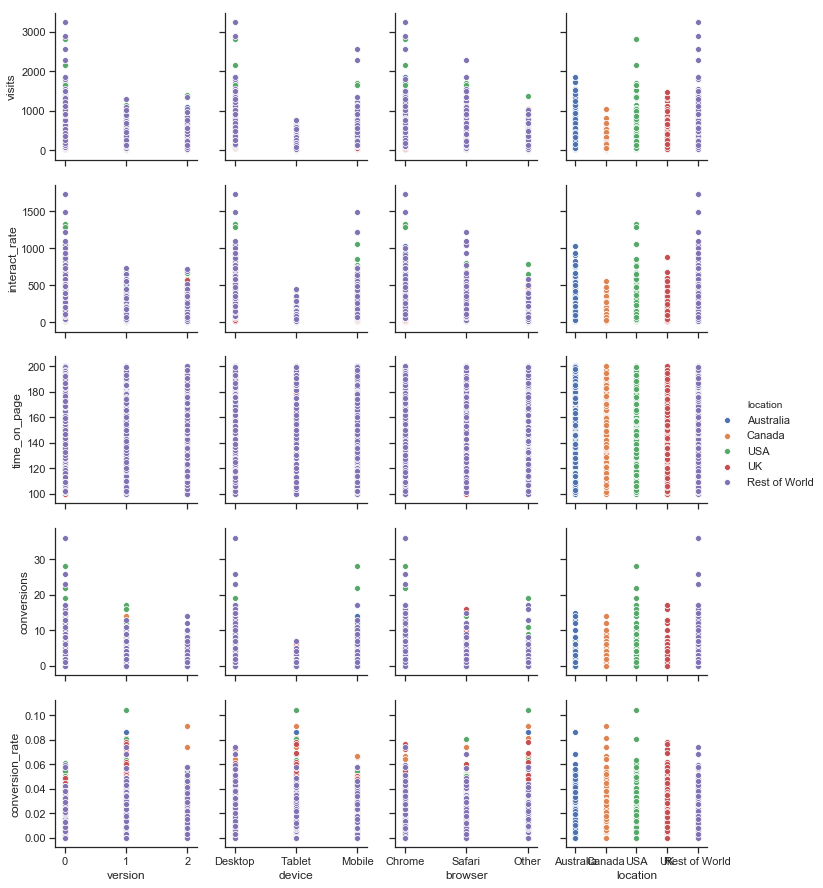

In [98]:
# pairplot of our dimensions vs. metrics
sns.pairplot(df, hue='location',
             x_vars=['version', 'device', 'browser', 'location'],
             y_vars=['visits', 'interact_rate', 'time_on_page', 'conversions', 'conversion_rate'])

In [103]:
# Looking at the stats of daily conversion rates confirms what we saw. 
# Version 1 gives the highest lift: 1.8% on average with a max of 10%. 
# Version 2 has a higher maximum daily lift compared to Version 2 but did not give as much lift on average.
for v in np.unique(df.version):
    print(df[df.version == v].conversion_rate.describe())

count    810.000000
mean       0.013403
std        0.011856
min        0.000000
25%        0.004754
50%        0.011226
75%        0.019018
max        0.060864
Name: conversion_rate, dtype: float64
count    810.000000
mean       0.018048
std        0.016884
min        0.000000
25%        0.003915
50%        0.015247
75%        0.027444
max        0.104167
Name: conversion_rate, dtype: float64
count    810.000000
mean       0.012994
std        0.013091
min        0.000000
25%        0.000000
50%        0.010965
75%        0.020427
max        0.090909
Name: conversion_rate, dtype: float64


* This is interesting. We immediately get a lift when using our alternative websites. So we are unto something here. However, with aggregated daily, the standard deviations are too large to draw significant conclusions.
* The experimental design seems to have divided our exposure s.t. `version 0 = version 1 + version 2`. So our lowest performing website got the most exposure.

Another thing to look at: how do the metrics vary in our feature space. Lets look at interacted_visit vs. conversion, broken down by location (column), browser (hue), version (row).

In [120]:
for v in np.unique(df.version):
    print(df[df.version == v].time_on_page.describe())

count    810.000000
mean     150.135802
std       29.773041
min      100.000000
25%      124.000000
50%      149.000000
75%      177.000000
max      200.000000
Name: time_on_page, dtype: float64
count    810.000000
mean     150.272840
std       29.030028
min      100.000000
25%      125.000000
50%      151.000000
75%      175.000000
max      200.000000
Name: time_on_page, dtype: float64
count    810.000000
mean     150.616049
std       29.490850
min      100.000000
25%      126.000000
50%      150.000000
75%      176.000000
max      200.000000
Name: time_on_page, dtype: float64


No big difference in time_on_page by the version of the website they saw. WOuld have expected a difference

## Conversion rate vs. date -- not significant

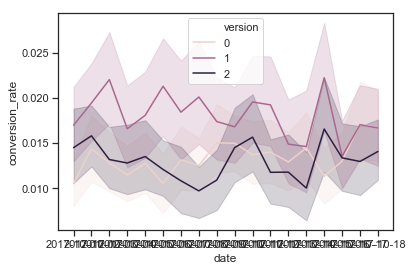

In [111]:
#Does this depend on time? Not really, lets ignore time for the rest of this analysis.
sns.lineplot(x='date', y='conversion_rate', hue='version', data=df);

## Version vs. Conversion rate -- Version 1 > Version 2 > Version 0

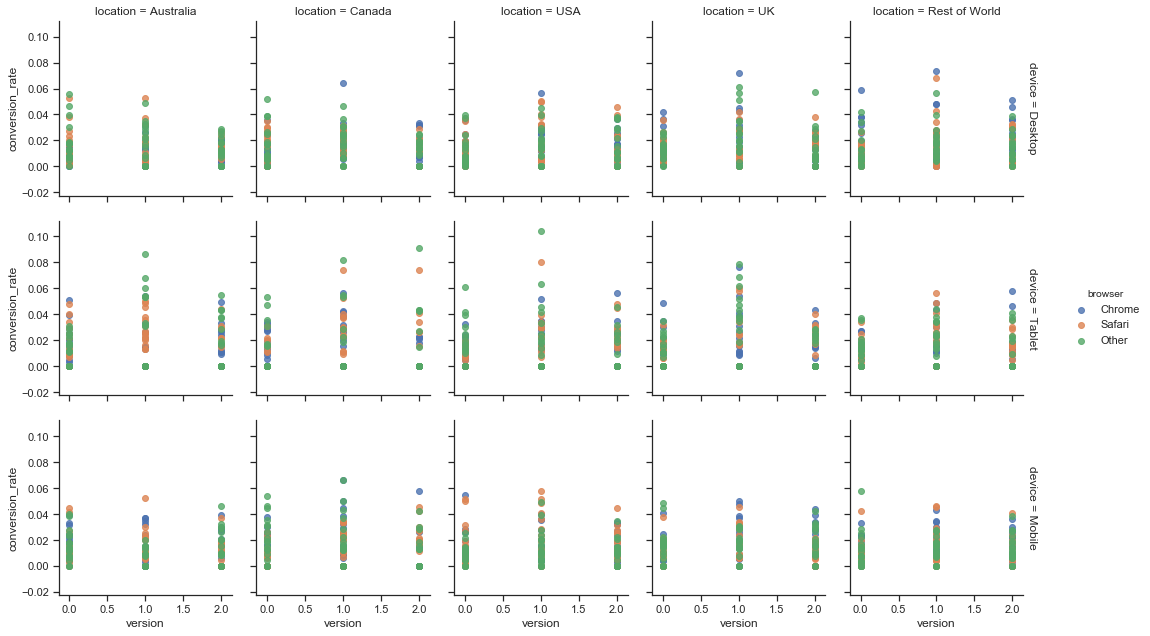

In [101]:
g = sns.FacetGrid(df, col="location", row='device', hue='browser', margin_titles=True)
g.map(sns.regplot, "version", "conversion_rate", fit_reg=False).add_legend();

`version 1` wins. It outperforms the other two in almost every location / device_type. American / Canadian tablet users liked Version 2 on some days.

Improvement: We should look at the mean/IQR (instead of just daily aggregations) for each of these distributions here. Maybe make a cutoff based on total number of users (in addition to rate).

## version vs. Bounce rate -- No difference in distribution

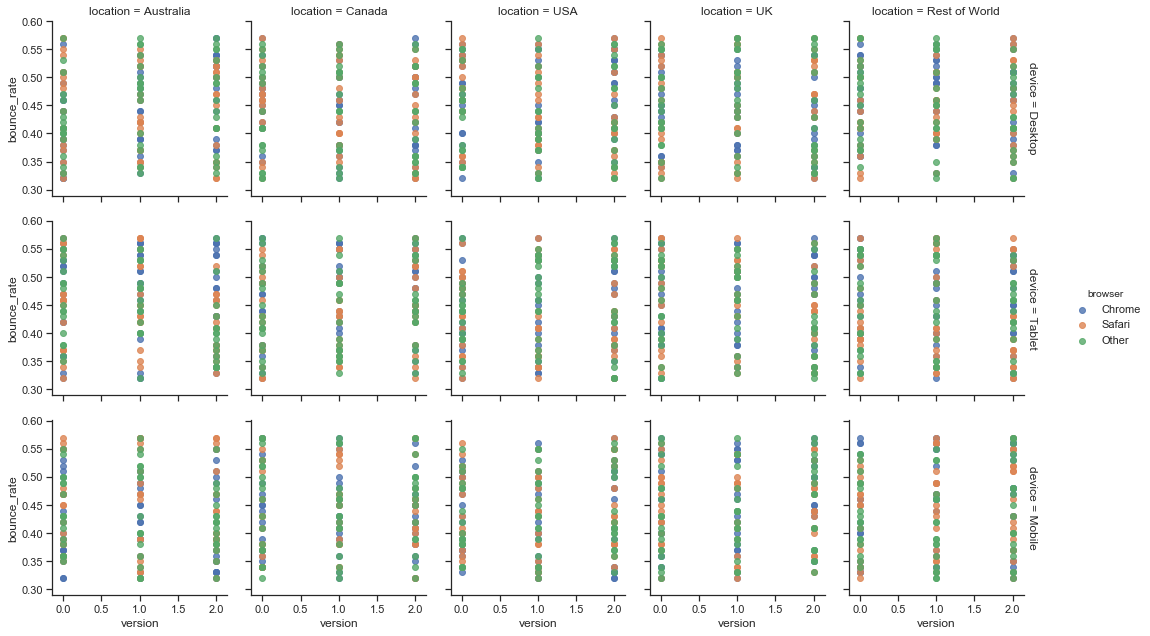

In [113]:
g = sns.FacetGrid(df, col="location", row='device', hue='browser', margin_titles=True)
g.map(sns.regplot, "version", "bounce_rate", fit_reg=False).add_legend();

## Version vs.time spent on page -- no real difference in distribution

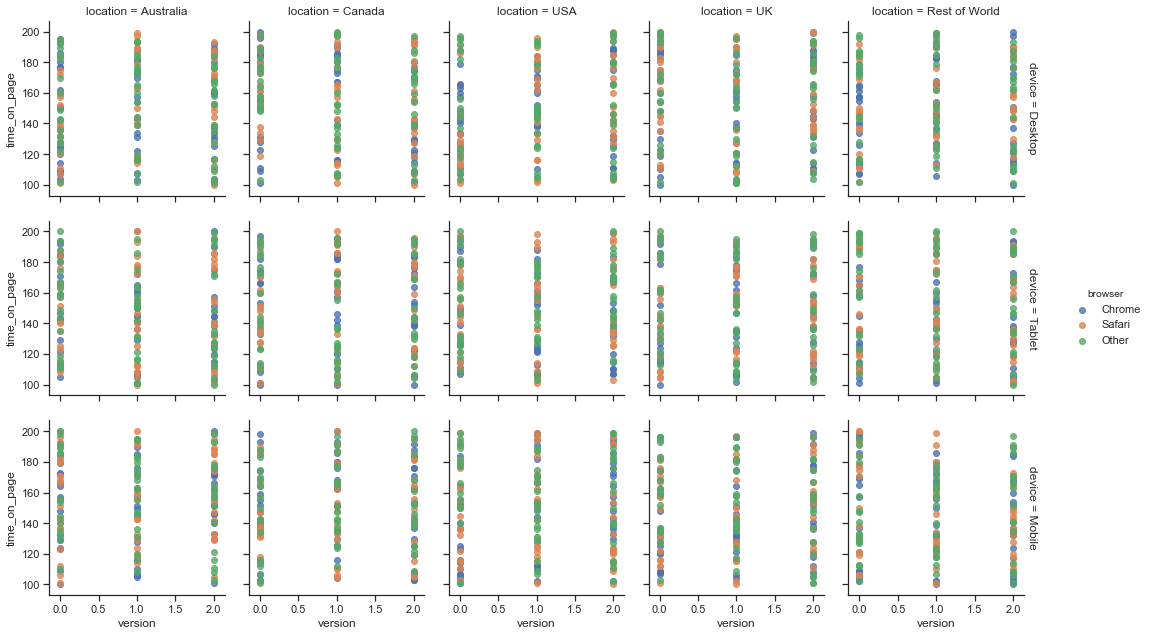

In [115]:
g = sns.FacetGrid(df, col="location", row='device', hue='browser', margin_titles=True)
g.map(sns.regplot, "version", "time_on_page", fit_reg=False).add_legend();

* Australia/USA + Chrome go well together. 
* Version 0 > Version > Version 2. 
* Generally Chrome users convert better, no matter which website.

This is a causal inference (CI) problem--not a prediction problem--with interactions between our variables . If I had more than two hours to spend on this problem, I would switch to R (unfortunately, CI packages are not that great in python -- `statsmodels` is barely decent). I would set up a multivariate linear regression with interaction terms:

    `model = lm(y ~ browser + device + location + 
                    browser*device + browser*location + device*location +
                    browser*device*location)`
                    
where 

    `y = conversion_rate`
                    
Given the high dimensionality of our data (compared with the number of visitors who interacted with our website) and the likely interactions between the variables, we need a Bayesian model to do this.